### 導入數據庫
   matplotlib.pyplot:繪圖 
   
   sklearn.neighbors 的 KNeighborsClassifier 來實現 k 近鄰投票和
   
   來自sklearn.metrics 的 accuracyscore 用於計算準確度分類分數。
   
   yfinance獲取股票數據(dataset)

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### 獲取數據

用pandas_datareader從 yahoo Finance 獲取 S&P 500 數據。存儲在“df”中

用“dropna”從數據中刪除所有NA值，並打印“Open”、“High”、“Low”、“Close”列的前五行。

In [2]:
# Read the data from Yahoo
df= pdr.get_data_yahoo('SPY', '2012-01-01', '2022-01-01')

df = df.dropna()
df = df[['Open', 'High', 'Low','Close']] #交易量考量 交易成本
df.head()

,Open,High,Low,Close
Date,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000
2012-01-04,127.199997,127.809998,126.709999,127.699997
2012-01-05,127.010002,128.229996,126.430000,128.039993
2012-01-06,128.199997,128.220001,127.290001,127.709999
2012-01-09,128.000000,128.179993,127.410004,128.020004


### 定義預測變量

用“Open-Close”和“High-Low”作為預測變量

刪除 NaN 值並將預測變量存在“X”中


In [3]:
# Predictor variables
df['Open-Close']= df.Open -df.Close
df['High-Low']  = df.High - df.Low
df =df.dropna()
X= df[['Open-Close', 'High-Low']]
X.head()

,Open-Close,High-Low
Date,,
2012-01-03,0.260002,0.950005
2012-01-04,-0.500000,1.099998
2012-01-05,-1.029991,1.799995
2012-01-06,0.489998,0.930000
2012-01-09,-0.020004,0.769989


### 定義目標變量

目標變量，是由預測變量預測其值的變量。其中，目標變量是 S&P500 在下一個交易日收盤價是上漲還是下跌。

邏輯是如果明天的收盤價高於今天的收盤價，那麼我們將買入 S&P 500，否則我們將賣出 S&P 500。

我們將為買入信號存儲+1，為賣出信號存儲-1。我們將目標變量存儲在變量“Y”中。

In [4]:
# Target variable
Y= np.where(df['Close'].shift(-1)>df['Close'],1,-1)

### 拆分數據集

將數據集拆分為訓練數據集和測試數據集。用 70% (可看情況改變但基本上至少有60%for training比較好)的數據進行訓練，其餘 30% 用於測試。

創建一個拆分參數，它將數據以 70-30 的比例劃分。

“Xtrain”和“Ytrain”是訓練數據集。 “Xtest”和“Ytest”是測試數據集。

In [5]:
# Splitting the dataset
split_percentage = 0.7
split = int(split_percentage*len(df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

### KNN實例

將數據集拆分為訓練數據集和測試數據集後實例 k-nearest classifier。這裡使用‘k =15’(也可以改變 k 的值)並觀察結果的變化。

使用“fit”函數擬合訓練數據。

用“accuracy_score”函數計算訓練和測試的準確性。

In [6]:
# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=15)

# fit the model
knn.fit(X_train, Y_train)

# Accuracy Score
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print ('訓練資料的準確度: %.2f' %accuracy_train)
print ('測試資料的準確度: %.2f' %accuracy_test) 

訓練資料的準確度: 0.60
測試資料的準確度: 0.55


### 使用模型創建交易策略

交易策略只是簡單的買入或賣出。使用預測功能預測買入或賣出的信號。然後計算測試數據集S&P500的累積投報。

接下來根據模型在測試數據集中預測的信號計算累積策略收益。

然後繪製 S&P 500 的累積收益和累積策略收益

可視化 KNN 算法的性能。

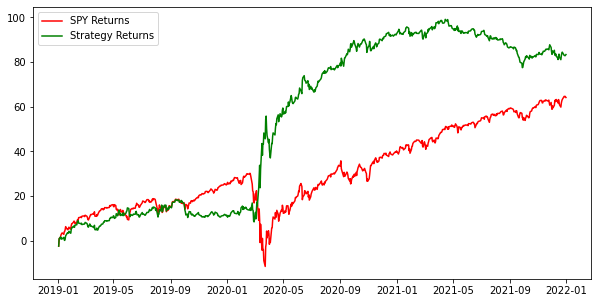

In [7]:
# Predicted Signal
df['Predicted_Signal'] = knn.predict(X)

# SPY Cumulative Returns
df['SPY_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_SPY_returns = df[split:]['SPY_returns'].cumsum()*100

# Cumulative Strategy Returns 
df['Startegy_returns'] = df['SPY_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = df[split:]['Startegy_returns'].cumsum()*100

# Plot the results to visualize the performance

plt.figure(figsize=(10,5))
plt.plot(Cumulative_SPY_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [8]:
knn.predict(X)

array([-1,  1, -1, ..., -1, -1, -1])

In [10]:
df[split:]['SPY_returns'].cumsum()*100

Date
2019-01-03    -2.415209
2019-01-04     0.879488
2019-01-07     1.664860
2019-01-08     2.600007
2019-01-09     3.066267
                ...    
2021-12-27    64.588081
2021-12-28    64.506328
2021-12-29    64.634167
2021-12-30    64.357331
2021-12-31    64.104994
Name: SPY_returns, Length: 756, dtype: float64

### 夏普率計算

夏普率是每單位波動率所獲得的超過市場回報 的回報。

計算累積收益的標準差，並用它進一步計算夏普率。

In [9]:
# Calculate Sharpe ratio
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-Cumulative_SPY_returns)/Std
Sharpe = Sharpe.mean()
print('夏普率: %.2f'%Sharpe )

夏普率: 0.64
